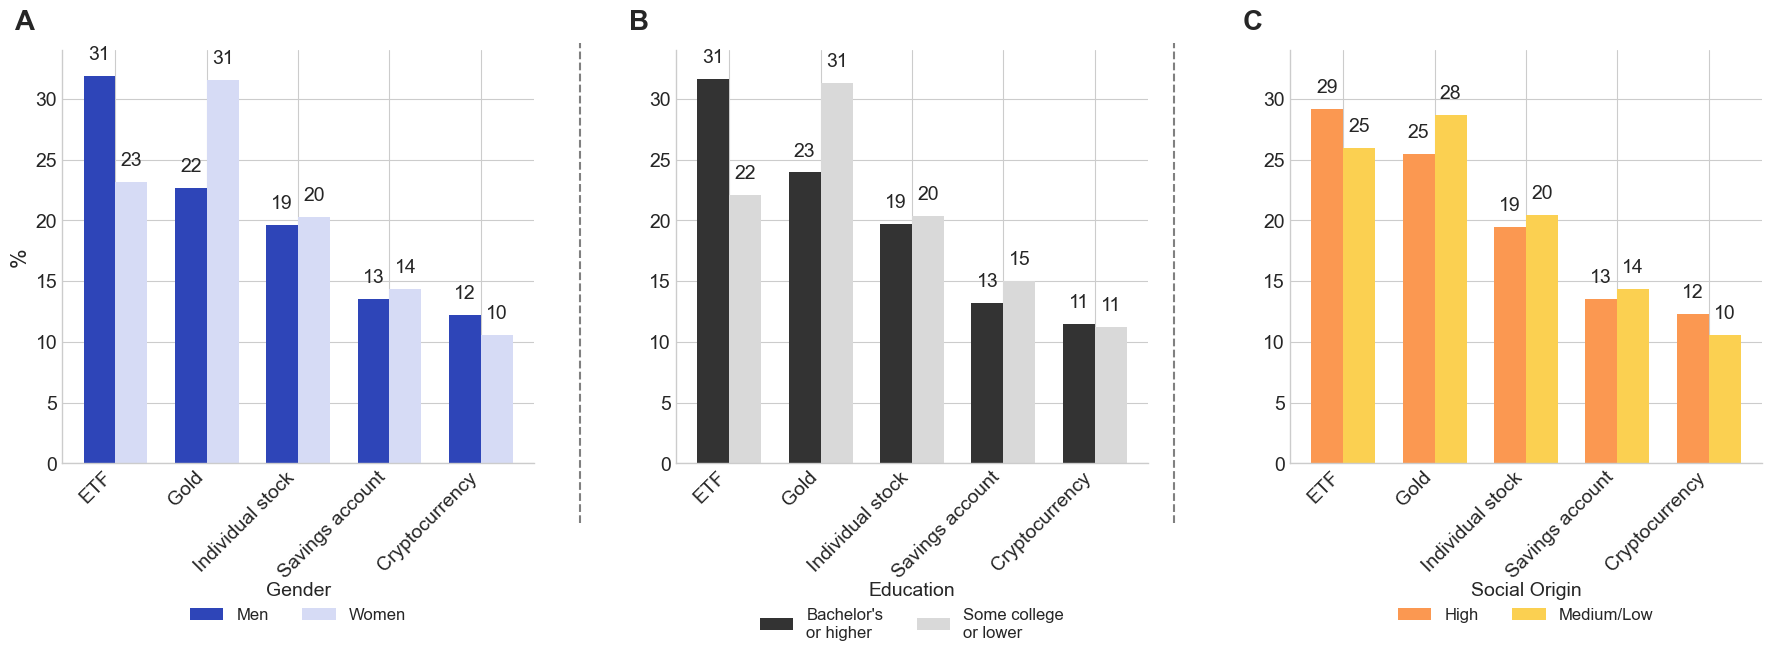

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the processed data
df = pd.read_pickle('/Users/jadmoawad/Desktop/Github_financial_experiment/financial-literacy-experiment/data/processed_df.pkl')

# Set default style
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 16})

# Tweak education factor labels with line breaks
df['education'] = pd.Categorical(df['education'])
education_mapping = {
    "Bachelor's or higher": "Bachelor's\nor higher",
    "Some college or lower": "Some college\nor lower"
}
df['education'] = df['education'].cat.rename_categories(education_mapping)

# Define color palettes for each subplot
colors_plot1 = ['#2E45B8', '#D6DBF5']
colors_plot2 = ['#333333', '#D9D9D9']
colors_plot3 = ['#FB9851', '#FBD051']

# Helper function to plot in a specific axis
def plot_in_axis(ax, data, group_var, colors):
    # Get unique groups
    groups = sorted(data[group_var].unique())
    
    # Prepare data
    investment_cols = ['stock', 'etf', 'saving', 'gold', 'crypto']
    investment_labels = {
        'etf': 'ETF',
        'gold': 'Gold',
        'stock': 'Individual stock',
        'saving': 'Savings account',
        'crypto': 'Cryptocurrency'
    }
    investment_order = ['ETF', 'Gold', 'Individual stock', 'Savings account', 'Cryptocurrency']
    
    # Calculate means
    means = {}
    for group in groups:
        group_data = data[data[group_var] == group]
        means[group] = []
        for inv_type in ['etf', 'gold', 'stock', 'saving', 'crypto']:
            means[group].append(group_data[inv_type].mean())
    
    # Plot bars
    x = np.arange(len(investment_order))
    width = 0.35
    
    for i, group in enumerate(groups):
        offset = width * (i - 0.5)
        bars = ax.bar(x + offset, means[group], width, 
                      label=group, color=colors[i])
        
        # Add value labels
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=14)
    
    # Customize
    ax.set_ylabel('%', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(investment_order, rotation=45, ha='right', fontsize=14)
    ax.set_ylim(0, 34)
    ax.tick_params(axis='y', labelsize=14)
    
    # Legend
    legend_title = group_var.replace('_', ' ').title()
    ax.legend(title=legend_title, loc='upper center', bbox_to_anchor=(0.5, -0.25),
             ncol=2, frameon=False, fontsize=12, title_fontsize=14)
    
    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Create figure with 3 subplots
fig = plt.figure(figsize=(18, 6))

# Create subplots with shared y-axis
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharey=ax1)
ax3 = plt.subplot(1, 3, 3, sharey=ax1)

# Plot in each axis
plot_in_axis(ax1, df, 'gender', colors_plot1)
plot_in_axis(ax2, df, 'education', colors_plot2)
plot_in_axis(ax3, df, 'social_origin', colors_plot3)

# Hide y-labels for middle and right plots
ax2.set_ylabel('')
ax3.set_ylabel('')

# Add panel labels
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, fontsize=20, fontweight='bold')
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, fontsize=20, fontweight='bold')
ax3.text(-0.1, 1.05, 'C', transform=ax3.transAxes, fontsize=20, fontweight='bold')

# Add vertical dashed lines between panels
fig.add_artist(plt.Line2D([0.33, 0.33], [0.1, 0.9], color='gray', 
                         linestyle='--', transform=fig.transFigure))
fig.add_artist(plt.Line2D([0.66, 0.66], [0.1, 0.9], color='gray', 
                         linestyle='--', transform=fig.transFigure))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.2, wspace=0.3)

# Save the figure
output_dir = "/Users/jadmoawad/Desktop/R_experiment/Figures"
os.makedirs(output_dir, exist_ok=True)

plt.savefig('/Users/jadmoawad/Desktop/Github_financial_experiment/financial-literacy-experiment/Figures/A_B_fig_1.png', 
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

# Display the plot
plt.show()

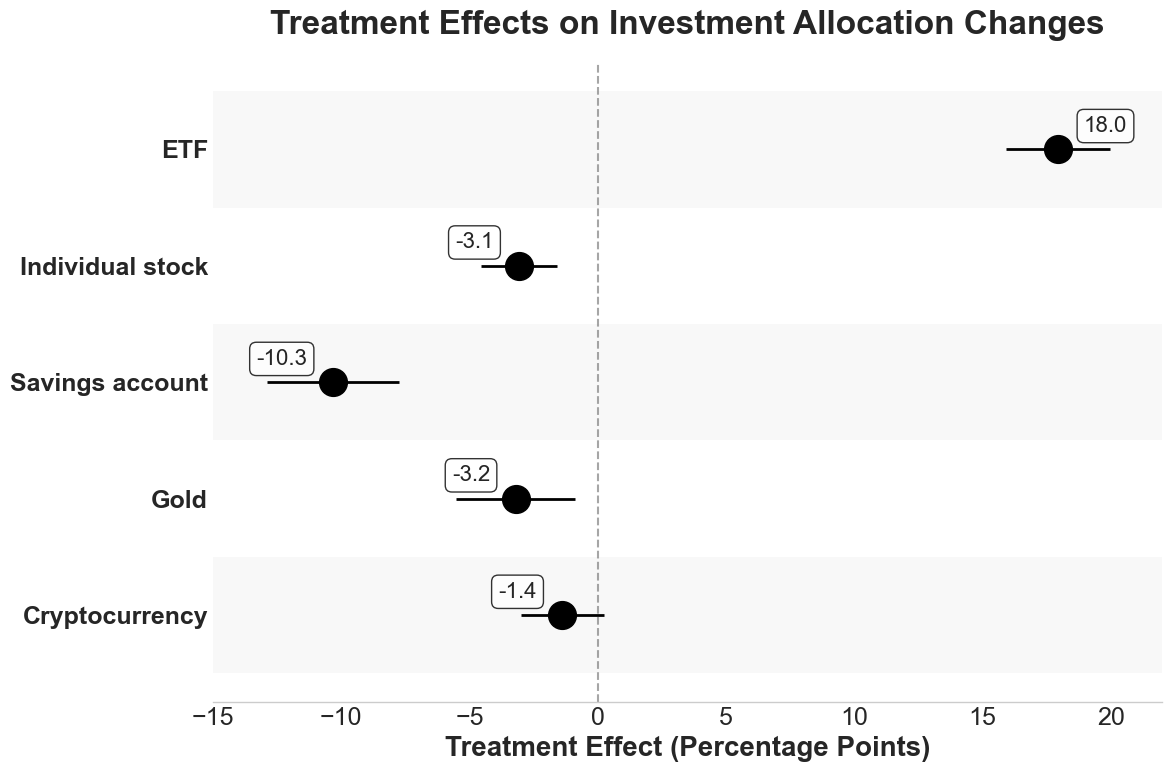

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import os
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_pickle('/Users/jadmoawad/Desktop/Github_financial_experiment/financial-literacy-experiment/data/processed_df.pkl')

# Create change variables
for asset in ['etf', 'stock', 'saving', 'gold', 'crypto']:
    df[f'{asset}_change'] = df[f'lot_{asset}'] - df[asset]

# Define control variables
control_vars = [
    'gender', 'education', 'social_origin', 'age', 'race', 
    'relationship_status', 'parents_us_born', 'labor_force', 
    'income', 'house', 'sub_financial_know', 'financial_literacy',
    'trust_government', 'political_placement', 'risk_tolerance'
]

# Run regressions and extract coefficients
model_names = ['ETF', 'Individual stock', 'Savings account', 'Gold', 'Cryptocurrency']
dependent_vars = ['etf_change', 'stock_change', 'saving_change', 'gold_change', 'crypto_change']

treatment_coefs = []
for dep_var, name in zip(dependent_vars, model_names):
    formula = f"{dep_var} ~ treatment + {' + '.join(control_vars)}"
    model = smf.ols(formula, data=df).fit(cov_type='HC1')
    
    treatment_coefs.append({
        'model': name,
        'estimate': model.params['treatment'],
        'conf_low': model.conf_int().loc['treatment', 0],
        'conf_high': model.conf_int().loc['treatment', 1],
        'p_value': model.pvalues['treatment']
    })

treatment_coefs = pd.DataFrame(treatment_coefs)
treatment_coefs['model'] = pd.Categorical(
    treatment_coefs['model'], 
    categories=model_names[::-1],
    ordered=True
)
treatment_coefs = treatment_coefs.sort_values('model')

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.axvline(x=0, linestyle='--', color='gray', linewidth=1.5, alpha=0.7)

# Plot coefficients
for i, (idx, row) in enumerate(treatment_coefs.iterrows()):
    if i % 2 == 0:
        ax.axhspan(i - 0.5, i + 0.5, facecolor='gray', alpha=0.05)
    
    ax.scatter(row['estimate'], i, s=400, color='black', zorder=3)
    ax.errorbar(row['estimate'], i, 
                xerr=[[row['estimate'] - row['conf_low']], 
                      [row['conf_high'] - row['estimate']]], 
                fmt='none', color='black', linewidth=2)
    
    # Add value labels
    x_offset = 1.0 if row['estimate'] > 0 else -1.0
    ha = 'left' if row['estimate'] > 0 else 'right'
    ax.text(row['estimate'] + x_offset, i + 0.2, f"{row['estimate']:.1f}", 
            ha=ha, va='center', fontsize=16, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# Style
ax.set_title('Treatment Effects on Investment Allocation Changes', fontsize=24, fontweight='bold', pad=20)
ax.set_xlabel('Treatment Effect (Percentage Points)', fontsize=20, fontweight='bold')
ax.set_yticks(range(len(treatment_coefs)))
ax.set_yticklabels(treatment_coefs['model'], fontsize=20, weight='bold')
ax.set_xlim(-15, 22)
ax.set_xticks([-15, -10, -5, 0, 5, 10, 15, 20])
ax.tick_params(labelsize=18, length=0)
ax.spines[['top', 'right', 'left']].set_visible(False)
ax.grid(False)

plt.tight_layout()
os.makedirs("/Users/jadmoawad/Desktop/R_experiment/Figures", exist_ok=True)
plt.savefig('/Users/jadmoawad/Desktop/Github_financial_experiment/financial-literacy-experiment/Figures/A_B_fig_2.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

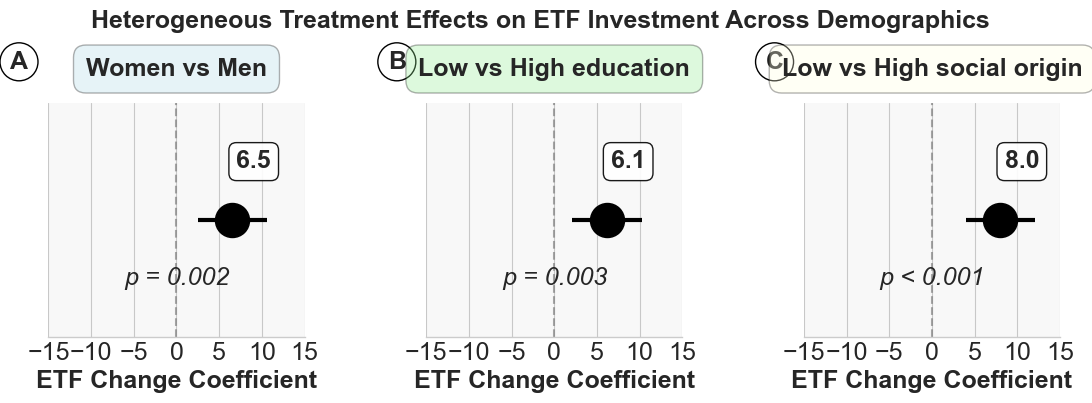

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import pyreadr
import os
import warnings
warnings.filterwarnings('ignore')

# Load data
result = pyreadr.read_r('/Users/jadmoawad/Desktop/Article 7 Experiment_redistribution/Data/df.Rda')
df = result[list(result.keys())[0]]
df['etf_change'] = df['lot_etf'] - df['etf']

# Controls
controls = ['age', 'race', 'relationship_status', 'parents_us_born', 'labor_force', 
            'income', 'house', 'sub_financial_know', 'financial_literacy', 
            'trust_government', 'political_placement', 'risk_tolerance']

# Configure demographics with their reference categories
demographics = {
    'gender': {
        'interaction': 'treatment:C(gender)[T.Women]',
        'title': 'Women vs Men',
        'color': 'lightblue'
    },
    'education': {
        'interaction': 'treatment:C(education)[T.Some college or lower]',
        'title': 'Low vs High education',
        'color': 'lightgreen'
    },
    'social_origin': {
        'interaction': 'treatment:C(social_origin)[T.Medium/Low]',
        'title': 'Low vs High social origin',
        'color': 'lightyellow'
    }
}

def plot_interaction(df, demo_var, config, ax):
    """Plot interaction effect for a demographic variable"""
    
    # Run regression
    formula = f"etf_change ~ treatment * C({demo_var}) + {' + '.join(controls)}"
    model = smf.ols(formula, data=df).fit(cov_type='HC1')
    
    # Extract coefficient
    interaction_term = config['interaction']
    if interaction_term not in model.params.index:
        # Fallback: find any treatment interaction term
        interaction_term = [k for k in model.params.index 
                          if f'treatment:C({demo_var})' in k][0]
    
    coef = model.params[interaction_term]
    ci_low, ci_high = model.conf_int().loc[interaction_term]
    p_val = model.pvalues[interaction_term]
    
    # Plot
    ax.axvline(0, linestyle='--', color='gray', linewidth=1.5, alpha=0.7)
    ax.scatter(coef, 0.5, s=600, color='black', zorder=3)
    ax.errorbar(coef, 0.5, xerr=[[coef - ci_low], [ci_high - coef]], 
               fmt='none', color='black', linewidth=3, capsize=0)
    
    # Add coefficient label
    x_pos = coef + 0.5 if coef > 0 else coef - 0.5
    h_align = 'left' if coef > 0 else 'right'
    ax.text(x_pos, 0.75, f"{coef:.1f}", ha=h_align, va='center', 
           fontsize=18, fontweight='bold',
           bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9))
    
    # Add p-value
    p_text = "p < 0.001" if p_val < 0.001 else f"p = {p_val:.3f}"
    ax.text(0.5, 0.25, p_text, ha='center', va='center', 
           transform=ax.transAxes, fontsize=18, style='italic')
    
    # Style axis
    ax.set_xlim(-15, 15)
    ax.set_ylim(0, 1)
    ax.set_xticks([-15, -10, -5, 0, 5, 10, 15])
    ax.set_yticks([])
    ax.tick_params(axis='x', labelsize=18, length=0)
    ax.axhspan(0, 1, facecolor='gray', alpha=0.05)
    
    # Remove spines
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)
    
    # Title
    ax.set_title(config['title'], fontsize=18, fontweight='bold', pad=20,
                bbox=dict(boxstyle="round,pad=0.5", facecolor=config['color'], alpha=0.3))
    ax.set_xlabel('ETF Change Coefficient', fontsize=18, fontweight='bold')

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Plot each demographic
for ax, (demo_var, config), label in zip(axes, demographics.items(), ['A', 'B', 'C']):
    plot_interaction(df, demo_var, config, ax)
    
    # Add panel label
    ax.text(-0.15, 1.15, label, fontsize=18, fontweight='bold', 
           transform=ax.transAxes,
           bbox=dict(boxstyle="circle,pad=0.3", facecolor='white', edgecolor='black'))

# Main title
fig.suptitle('Heterogeneous Treatment Effects on ETF Investment Across Demographics', 
            fontsize=18, fontweight='bold', y=0.75)

# Layout and save
plt.tight_layout(pad=3.0)
output_path = '/Users/jadmoawad/Desktop/Github_financial_experiment/financial-literacy-experiment/Figures/A_B_fig_3.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()